# Medida de proximidad

* Se mide la proximidad utilizando un método basado en resultados, en particular, basado en la suposición de que es más probable que productos similares se exporten en conjunto. 

* Para eso se requiere una medida estricta de las exportaciones. Se excluyen exportaciones marginales a través de la selección de exportaciones con Ventajas Comparativas Reveladas (VCR). Hidalgo et al (2007) usan la definición de Balassa (1986) de VCR.

### Cálculo de VCR (Balassa)

$ VCR_{ci} = \frac{ \frac{X_{ci}}{X_c} }{ \frac{X_{wi}}{X_w} } $ 

Donde $X_{ci}$ son las exportaciones del producto i del país c, mientras que $X_c$ son las exportaciones totales del país c. En el denominador se encuentran los análogos del resto del mundo (w).

## Datos de Comercio

En el paper original se usan productos desagregados según la SITC revisión 4 a nivel de cuatro dígitos, de la base de datos de UNCOMTRADE. En este caso se utilizarán datos de WITS correspondientes al sistema armonizado (HS) a 4 dígitos (ver extrating data de la carpeta de raw data => WITS).  

Se decide no utilizar datos de 2020 porque es un año de pandemia que podría tener una comportamiento distinto a la tendencia y la idea es comparar evolución sin atender a las consecuencias de la pandemia. En otra futura investigación, cuando exista información completa de flujos comerciales, podría ser interesante comparar tendencias pre y post pandemia. 

Levanto los datos ya preprocesados.

In [30]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
import pickle
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [223]:
df = pd.read_csv('../data/processed/datos_expo_para_vcr.csv', index_col=None)

In [224]:
df

,ReporterISO3,ProductCode,ReporterName,1997,1998,1999,2007,2008,2009,2017,2018,2019,prom_1719,prom_0709,prom_9799
0,ABW,101,Aruba,NaN,NaN,NaN,1.809,1.285,4.476,6.145,5.397,8.483,6.68,2.52,NaN
1,ABW,103,Aruba,NaN,NaN,NaN,NaN,NaN,0.084,NaN,NaN,NaN,NaN,0.08,NaN
2,ABW,104,Aruba,NaN,NaN,NaN,0.642,0.017,NaN,NaN,NaN,NaN,NaN,0.33,NaN
3,ABW,105,Aruba,NaN,NaN,NaN,6.849,1.531,4.473,27.374,73.884,47.781,49.68,4.28,NaN
4,ABW,106,Aruba,NaN,NaN,NaN,5.834,10.069,10.007,12.024,10.594,4.669,9.10,8.64,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179597,ZWE,9702,Zimbabwe,NaN,NaN,NaN,NaN,0.002,NaN,0.655,NaN,NaN,0.66,0.00,NaN
179598,ZWE,9703,Zimbabwe,NaN,NaN,NaN,4844.384,690.542,966.129,2261.126,2253.457,2172.791,2229.12,2167.02,NaN
179599,ZWE,9704,Zimbabwe,NaN,NaN,NaN,2.376,NaN,NaN,NaN,NaN,NaN,NaN,2.38,NaN
179600,ZWE,9705,Zimbabwe,NaN,NaN,NaN,30099.052,29621.528,14193.067,8866.771,8995.939,8252.694,8705.13,24637.88,NaN


In [225]:
# si quisiera seleccionar solo columnas numéricas 
# numeric_inputs = df.select_dtypes(include=np.number)
df['ProductCode'].nunique()

1242

## Selección de productos

In [385]:
clasif = pd.read_csv('../data/raw/HS1996Description.csv', encoding= 'unicode_escape')

In [386]:
clasif

,HS 1996 Product Code,HS 1996 Product Description
0,101,"Live horses, asses, mules and hinnies."
1,102,Live bovine animals.
2,103,Live swine.
3,104,Live sheep and goats.
4,105,"Live poultry, that is to say, fowls of the spe..."
...,...,...
1313,9893,UN Special Code
1314,9894,UN Special Code
1315,9895,UN Special Code
1316,9896,UN Special Code


In [387]:
clasif = clasif.rename(columns={'HS 1996 Product Code': 'HS_code', 'HS 1996 Product Description': 'HS_description'})

Hay una serie de 77 productos que van del código HS 9802 en adelante que corresponden a un código especial de naciones unidas ("UN Special Code"). Como no hay distinción de qué productos se trata se decide eliminarlos de la base. 

In [388]:
clasif[clasif['HS_code']>=9802]

,HS_code,HS_description
1241,9802,UN Special Code
1242,9804,UN Special Code
1243,9807,UN Special Code
1244,9808,UN Special Code
1245,9809,UN Special Code
...,...,...
1313,9893,UN Special Code
1314,9894,UN Special Code
1315,9895,UN Special Code
1316,9896,UN Special Code


In [389]:
list_unspecial = clasif[clasif['HS_code']>=9802].HS_code

In [228]:
df_ = df[["ReporterISO3", "ProductCode", 'ReporterName', 'prom_1719', 'prom_0709', 'prom_9799']]
df_

,ReporterISO3,ProductCode,ReporterName,prom_1719,prom_0709,prom_9799
0,ABW,101,Aruba,6.68,2.52,NaN
1,ABW,103,Aruba,NaN,0.08,NaN
2,ABW,104,Aruba,NaN,0.33,NaN
3,ABW,105,Aruba,49.68,4.28,NaN
4,ABW,106,Aruba,9.10,8.64,NaN
...,...,...,...,...,...,...
179597,ZWE,9702,Zimbabwe,0.66,0.00,NaN
179598,ZWE,9703,Zimbabwe,2229.12,2167.02,NaN
179599,ZWE,9704,Zimbabwe,NaN,2.38,NaN
179600,ZWE,9705,Zimbabwe,8705.13,24637.88,NaN


In [229]:
df_['ProductCode'].nunique()

1242

In [230]:
df_ = df_[~df_.ProductCode.isin(list_unspecial)] # se excluyen las posiciones especiales de NU 

In [231]:
df_['ProductCode'].nunique() # solo se encontró una posición especial: la 9999 y se elimina de la base quedando 1241 bienes

1241

Sólo se encontró una posición especial en la base de datos con la que estamos trabajando (la 9999), quedando 1241 bienes con los que se trabajará. 

## Selección de países

*¿Qué hacer con los datos faltantes de países?*

No hay información de comercio completa para los 193 países de la base de datos en todos los años a estudiar. Para hacer comparables los análisis se decide unificar la cantidad de países en todos los años estudiados. Para eso se optó por trabajar en dos líneas distintas: 

1) Por un lado, tomar sólo los países que hay información completa para todo el período en análisis. Existen 84 países para los que hay faltante de datos en al menos uno de los períodos considerados. Es decir, se consideran sólo los restantes países de la base para los que si figuran datos de exportaciones: **109 países, que representan el aprox. 82% de las exportaciones mundiales en 07/09 y 17/19, y 95,7% en 97/99**. ==> **df1**  

2) Por otro, se decide trabajar sólo con los últimos dos períodos de datos ya que la mayoría de los datos faltantes corresponden a información de la década del 90 (67 países sin datos). Por tanto se eliminarán los países sin información para los últimos dos períodos: 34 países en total, que representan menos del 1% del total comerciado en ambos períodos. Se trabajará entonces con **157 países que representan más del 99% de las exportaciones mundiales para los períodos 0709 y 1719**.==>  **df2**

In [234]:
# cuento los países para los que no se disponen de datos en los distintos años
# mayoría de faltantes en 9799
print(df_[['ReporterISO3', "ReporterName", 'prom_9799']].groupby(by=["ReporterName"]).sum().eq(0).sum()) # 67 países no tienen datos para 9799
print(df_[['ReporterISO3', "ReporterName", 'prom_0709']].groupby(by=["ReporterName"]).sum().eq(0).sum()) # 13 países no tienen datos para 0709
print(df_[['ReporterISO3', "ReporterName", 'prom_1719']].groupby(by=["ReporterName"]).sum().eq(0).sum()) # 27 países no tienen datos para 1719
# coinciden con los calculados antes

prom_9799    67
dtype: int64
prom_0709    13
dtype: int64
prom_1719    27
dtype: int64


In [235]:
# armo listas con los países que tienen faltantes de datos
paises_null_9799 = df_[['ReporterISO3', "ReporterName", 'prom_9799']].groupby(by=["ReporterISO3","ReporterName"]).sum().reset_index()
list_paises_null_9799 = paises_null_9799[paises_null_9799.prom_9799==0.0].ReporterISO3
print(len(list_paises_null_9799)) # 67 países
paises_null_0709 = df_[['ReporterISO3', "ReporterName", 'prom_0709']].groupby(by=["ReporterISO3","ReporterName"]).sum().reset_index()
list_paises_null_0709 = paises_null_0709[paises_null_0709.prom_0709==0.0].ReporterISO3
print(len(list_paises_null_0709)) # 13 países
paises_null_1719 = df_[['ReporterISO3', "ReporterName", 'prom_1719']].groupby(by=["ReporterISO3","ReporterName"]).sum().reset_index()
list_paises_null_1719 = paises_null_1719[paises_null_1719.prom_1719==0.0].ReporterISO3
print(len(list_paises_null_1719)) # 27 países

67
13
27


In [236]:
# uno las listas de países
total_null_countries = list_paises_null_9799.append(list_paises_null_0709).append(list_paises_null_1719).unique()
print(len(total_null_countries))
total_null_countries # 84 países en total sin datos en al menos uno de los períodos estudiados

84


array(['ABW', 'AFG', 'AGO', 'BDI', 'BFA', 'BGD', 'BHR', 'BIH', 'BMU',
       'BRB', 'BRN', 'BWA', 'CIV', 'CMR', 'COG', 'COK', 'COM', 'DJI',
       'DOM', 'EGY', 'ETH', 'EUN', 'FJI', 'FSM', 'GHA', 'GRD', 'KGZ',
       'KHM', 'KIR', 'KWT', 'LAO', 'LBY', 'LCA', 'LSO', 'MAR', 'MDA',
       'MMR', 'MNT', 'MRT', 'MYT', 'NAM', 'NCL', 'OAS', 'OMN', 'PAK',
       'PHL', 'PLW', 'PSE', 'QAT', 'RWA', 'SER', 'SLB', 'SLE', 'SUD',
       'SUR', 'SWZ', 'SYR', 'TMP', 'TON', 'TUN', 'UKR', 'UZB', 'VNM',
       'VUT', 'WSM', 'YEM', 'ZWE', 'BLX', 'CUB', 'HTI', 'IRN', 'TKM',
       'ANT', 'BTN', 'DMA', 'FRO', 'GAB', 'GIN', 'MSR', 'PYF', 'SDN',
       'TCA', 'TTO', 'VEN'], dtype=object)

In [237]:
# si considero faltantes solo de los últimos 2 períodos
list_paises_null_2per = list_paises_null_0709.append(list_paises_null_1719).unique()
len(list_paises_null_2per) # serían 36 países menos en vez de 84

36

In [239]:
dt_tot = pd.DataFrame(df_[["ReporterISO3", "ProductCode", 'ReporterName', 'prom_1719', 'prom_0709', 'prom_9799']].sum(numeric_only=True))
dt_tot

,0
ProductCode,9.709373e+08
prom_1719,1.929291e+10
prom_0709,1.445432e+10
prom_9799,5.025853e+09


In [240]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179422 entries, 0 to 179600
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ReporterISO3  179422 non-null  object 
 1   ProductCode   179422 non-null  int64  
 2   ReporterName  179422 non-null  object 
 3   prom_1719     147147 non-null  float64
 4   prom_0709     151945 non-null  float64
 5   prom_9799     108102 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 9.6+ MB


In [241]:
dt_sin_null = pd.DataFrame(df_[~df_.ReporterISO3.isin(total_null_countries)].sum(numeric_only=True))
dt_sin_null
dt_sin_null.index

Index(['ProductCode', 'prom_1719', 'prom_0709', 'prom_9799'], dtype='object')

In [242]:
# si extrajera todos los países con datos faltantes
compare = pd.merge(dt_sin_null, dt_tot, how='left', on=dt_sin_null.index)
compare['dif'] = compare['0_y'] - compare['0_x'] # valor absoluto que dejaría afuera
compare['%overtot'] = round(compare['0_x']/compare['0_y']*100,2) # porcentaje del comercio que quedaría abarcado por el estudio
compare

,key_0,0_x,0_y,dif,%overtot
0,ProductCode,6.271679e+08,9.709373e+08,3.437694e+08,64.59
1,prom_1719,1.583311e+10,1.929291e+10,3.459793e+09,82.07
2,prom_0709,1.189768e+10,1.445432e+10,2.556639e+09,82.31
3,prom_9799,4.811163e+09,5.025853e+09,2.146903e+08,95.73


In [243]:
# si extrajera solo 36 países y tomara comparación entre los últimos dos períodos
compare2 = pd.merge(pd.DataFrame(df_[~df_.ReporterISO3.isin(list_paises_null_2per)].sum(numeric_only=True)), dt_tot, how='left', on=dt_tot.index)
compare2['dif'] = compare2['0_y'] - compare2['0_x'] # valor absoluto que dejaría afuera
compare2['%overtot'] = round(compare2['0_x']/compare2['0_y']*100,2) # porcentaje del comercio que quedaría abarcado por el estudio
compare2 

,key_0,0_x,0_y,dif,%overtot
0,ProductCode,8.658948e+08,9.709373e+08,1.050425e+08,89.18
1,prom_1719,1.915471e+10,1.929291e+10,1.381950e+08,99.28
2,prom_0709,1.432196e+10,1.445432e+10,1.323596e+08,99.08
3,prom_9799,4.811163e+09,5.025853e+09,2.146903e+08,95.73


In [244]:
print(len(df_[~df_.ReporterISO3.isin(list_paises_null_2per)].ReporterISO3.unique())) # 157 países
len(df_[~df_.ReporterISO3.isin(total_null_countries)].ReporterISO3.unique())

157


109

In [246]:
# creo df1: excluyo todos los países que tuvieron faltante en alguno de los períodos bajo análisis 
df1 = df_[~df_.ReporterISO3.isin(total_null_countries)]
df1 # 116654 rows × 6 columns

,ReporterISO3,ProductCode,ReporterName,prom_1719,prom_0709,prom_9799
1889,ALB,101,Albania,NaN,NaN,8.62
1890,ALB,104,Albania,NaN,2.64,NaN
1891,ALB,105,Albania,NaN,NaN,10.61
1892,ALB,106,Albania,NaN,501.09,24.35
1893,ALB,201,Albania,NaN,NaN,3.19
...,...,...,...,...,...,...
178597,ZMB,9702,Zambia,0.02,0.64,0.72
178598,ZMB,9703,Zambia,1.54,35.66,297.76
178599,ZMB,9704,Zambia,NaN,3.28,0.21
178600,ZMB,9705,Zambia,874.84,846.11,3.04


In [249]:
# creo df2: excluyo los países que tuvieron faltantes en los últimos dos períodos
df2 = df_[~df_.ReporterISO3.isin(list_paises_null_2per)]
df2 = df2[["ReporterISO3", "ProductCode", 'ReporterName', 'prom_1719', 'prom_0709']]
df2 # 160577 rows × 5 columns

,ReporterISO3,ProductCode,ReporterName,prom_1719,prom_0709
0,ABW,101,Aruba,6.68,2.52
1,ABW,103,Aruba,NaN,0.08
2,ABW,104,Aruba,NaN,0.33
3,ABW,105,Aruba,49.68,4.28
4,ABW,106,Aruba,9.10,8.64
...,...,...,...,...,...
179596,ZWE,9701,Zimbabwe,59.62,16.82
179597,ZWE,9702,Zimbabwe,0.66,0.00
179598,ZWE,9703,Zimbabwe,2229.12,2167.02
179599,ZWE,9704,Zimbabwe,NaN,2.38


## Calculo VCR 

$ VCR_{ci} = \frac{ \frac{X_{ci}}{X_c} }{ \frac{X_{wi}}{X_w} } $ 

Gran parte del código que se aplica a continuación proviene de [QuantEconNotes](https://notes.quantecon.org/submission/5b32e9b0b9eab00015b89f7d) adaptado a los datos con los que estamos trabajando. Siempre siguiendo los lineamientos de la presente investigación y el paper original de Hidalgo et al. (2007). 

### <span style="color:steelblue">Dataset 1: </span>: todos los períodos - 109 países

In [251]:
# calculo datos para df1 
list_years1 = ['1719', '0709', '9799']
# armo los datos para el cálculo según la fórmula de Balassa
for i in list_years1:
    # renombro columna de prom de expo 1719
    df1.rename(columns = {'prom_'+i:'X_c_prod_'+i}, inplace = True)
    # armo columna con el total de expo por pais
    df1['X_c_'+i] = df1[["ReporterName", 'X_c_prod_'+i]].groupby(by=["ReporterName"]).transform(np.sum)
    # armo una columna con el total de expo por producto (total mundial) 
    df1['X_w_prod_'+i] = df1[['ProductCode', 'X_c_prod_'+i]].groupby(by=["ProductCode"]).transform(np.sum)
    # armo una columna con el total de expo mundial (sumo todos los paises de la base)
    df1['X_w_'+i] = np.repeat(df1[['X_c_prod_'+i]].sum(), len(df1)).to_numpy()

<ipython-input-251-c3d83c676353>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['X_c_'+i] = df1[["ReporterName", 'X_c_prod_'+i]].groupby(by=["ReporterName"]).transform(np.sum)
<ipython-input-251-c3d83c676353>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['X_w_prod_'+i] = df1[['ProductCode', 'X_c_prod_'+i]].groupby(by=["ProductCode"]).transform(np.sum)
<ipython-input-251-c3d83c676353>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [252]:
df1 # 116654 rows × 15 columns

,ReporterISO3,ProductCode,ReporterName,X_c_prod_1719,X_c_prod_0709,X_c_prod_9799,X_c_1719,X_w_prod_1719,X_w_1719,X_c_0709,X_w_prod_0709,X_w_0709,X_c_9799,X_w_prod_9799,X_w_9799
1889,ALB,101,Albania,NaN,NaN,8.62,1317182.28,2825047.29,1.583311e+10,915854.65,2238355.29,1.189768e+10,241019.19,1209251.89,4.811163e+09
1890,ALB,104,Albania,NaN,2.64,NaN,1317182.28,1051436.52,1.583311e+10,915854.65,801511.80,1.189768e+10,241019.19,539434.37,4.811163e+09
1891,ALB,105,Albania,NaN,NaN,10.61,1317182.28,3107574.84,1.583311e+10,915854.65,2057194.92,1.189768e+10,241019.19,904641.94,4.811163e+09
1892,ALB,106,Albania,NaN,501.09,24.35,1317182.28,983975.35,1.583311e+10,915854.65,699320.16,1.189768e+10,241019.19,329126.39,4.811163e+09
1893,ALB,201,Albania,NaN,NaN,3.19,1317182.28,23409292.56,1.583311e+10,915854.65,17614112.15,1.189768e+10,241019.19,8378105.51,4.811163e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178597,ZMB,9702,Zambia,0.02,0.64,0.72,7998239.78,596116.34,1.583311e+10,4505339.19,369166.50,1.189768e+10,1108720.41,160879.06,4.811163e+09
178598,ZMB,9703,Zambia,1.54,35.66,297.76,7998239.78,4046051.44,1.583311e+10,4505339.19,2221386.19,1.189768e+10,1108720.41,534416.91,4.811163e+09
178599,ZMB,9704,Zambia,NaN,3.28,0.21,7998239.78,121002.87,1.583311e+10,4505339.19,170333.51,1.189768e+10,1108720.41,180064.20,4.811163e+09
178600,ZMB,9705,Zambia,874.84,846.11,3.04,7998239.78,1170342.17,1.583311e+10,4505339.19,489670.76,1.189768e+10,1108720.41,330109.02,4.811163e+09


In [253]:
# cuento los países para los que no se disponen de datos en los distintos años
# chequeo que dan 0
print(df1[["ReporterName", 'X_c_prod_9799']].groupby(by=["ReporterName"]).sum().eq(0).sum()) # 0 países no tienen datos para 9799
print(df1[["ReporterName", 'X_c_prod_0709']].groupby(by=["ReporterName"]).sum().eq(0).sum()) # 0 países no tienen datos para 0709
print(df1[["ReporterName", 'X_c_prod_1719']].groupby(by=["ReporterName"]).sum().eq(0).sum()) # 0 países no tienen datos para 1719
# coinciden con los calculados antes

X_c_prod_9799    0
dtype: int64
X_c_prod_0709    0
dtype: int64
X_c_prod_1719    0
dtype: int64


In [254]:
# cálculo VCR según la fórmula de Balassa usando las columnas previamente creadas
for i in list_years1:
    df1['VCR_ci'+i] = (df1['X_c_prod_'+i] / df1['X_c_'+i]) / (df1['X_w_prod_'+i] / df1['X_w_'+i])

<ipython-input-254-6c45812d5d90>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['VCR_ci'+i] = (df1['X_c_prod_'+i] / df1['X_c_'+i]) / (df1['X_w_prod_'+i] / df1['X_w_'+i])


In [255]:
df1 # 116654 rows × 18 columns

,ReporterISO3,ProductCode,ReporterName,X_c_prod_1719,X_c_prod_0709,X_c_prod_9799,X_c_1719,X_w_prod_1719,X_w_1719,X_c_0709,X_w_prod_0709,X_w_0709,X_c_9799,X_w_prod_9799,X_w_9799,VCR_ci1719,VCR_ci0709,VCR_ci9799
1889,ALB,101,Albania,NaN,NaN,8.62,1317182.28,2825047.29,1.583311e+10,915854.65,2238355.29,1.189768e+10,241019.19,1209251.89,4.811163e+09,NaN,NaN,0.142295
1890,ALB,104,Albania,NaN,2.64,NaN,1317182.28,1051436.52,1.583311e+10,915854.65,801511.80,1.189768e+10,241019.19,539434.37,4.811163e+09,NaN,0.042789,NaN
1891,ALB,105,Albania,NaN,NaN,10.61,1317182.28,3107574.84,1.583311e+10,915854.65,2057194.92,1.189768e+10,241019.19,904641.94,4.811163e+09,NaN,NaN,0.234119
1892,ALB,106,Albania,NaN,501.09,24.35,1317182.28,983975.35,1.583311e+10,915854.65,699320.16,1.189768e+10,241019.19,329126.39,4.811163e+09,NaN,9.308406,1.476844
1893,ALB,201,Albania,NaN,NaN,3.19,1317182.28,23409292.56,1.583311e+10,915854.65,17614112.15,1.189768e+10,241019.19,8378105.51,4.811163e+09,NaN,NaN,0.007601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178597,ZMB,9702,Zambia,0.02,0.64,0.72,7998239.78,596116.34,1.583311e+10,4505339.19,369166.50,1.189768e+10,1108720.41,160879.06,4.811163e+09,0.000066,0.004578,0.019421
178598,ZMB,9703,Zambia,1.54,35.66,297.76,7998239.78,4046051.44,1.583311e+10,4505339.19,2221386.19,1.189768e+10,1108720.41,534416.91,4.811163e+09,0.000753,0.042393,2.417766
178599,ZMB,9704,Zambia,NaN,3.28,0.21,7998239.78,121002.87,1.583311e+10,4505339.19,170333.51,1.189768e+10,1108720.41,180064.20,4.811163e+09,NaN,0.050852,0.005061
178600,ZMB,9705,Zambia,874.84,846.11,3.04,7998239.78,1170342.17,1.583311e+10,4505339.19,489670.76,1.189768e+10,1108720.41,330109.02,4.811163e+09,1.479748,4.563072,0.039962


In [256]:
df1['ProductCode'].nunique()

1241

In [257]:
df1['ProductCode'].to_numpy()

array([ 101,  104,  105, ..., 9704, 9705, 9706], dtype=int64)

### <span style="color:steelblue">Dataset 2: </span>últimos 2 períodos - 157 países

In [258]:
# calculo datos para df1 
list_years2 = ['1719', '0709']
# armo los datos para el cálculo según la fórmula de Balassa
for i in list_years2:
    # renombro columna de prom de expo 1719
    df2.rename(columns = {'prom_'+i:'X_c_prod_'+i}, inplace = True)
    # armo columna con el total de expo por pais
    df2['X_c_'+i] = df2[["ReporterName", 'X_c_prod_'+i]].groupby(by=["ReporterName"]).transform(np.sum)
    # armo una columna con el total de expo por producto (total mundial) 
    df2['X_w_prod_'+i] = df2[['ProductCode', 'X_c_prod_'+i]].groupby(by=["ProductCode"]).transform(np.sum)
    # armo una columna con el total de expo mundial (sumo todos los paises de la base)
    df2['X_w_'+i] = np.repeat(df2[['X_c_prod_'+i]].sum(), len(df2)).to_numpy()

In [259]:
df2 # 160577 rows × 11 columns

,ReporterISO3,ProductCode,ReporterName,X_c_prod_1719,X_c_prod_0709,X_c_1719,X_w_prod_1719,X_w_1719,X_c_0709,X_w_prod_0709,X_w_0709
0,ABW,101,Aruba,6.68,2.52,78039.01,3667767.66,1.915471e+10,122628.16,2862192.06,1.432196e+10
1,ABW,103,Aruba,NaN,0.08,78039.01,4380146.96,1.915471e+10,122628.16,4042478.24,1.432196e+10
2,ABW,104,Aruba,NaN,0.33,78039.01,1469510.11,1.915471e+10,122628.16,859653.93,1.432196e+10
3,ABW,105,Aruba,49.68,4.28,78039.01,3528427.57,1.915471e+10,122628.16,2346975.92,1.432196e+10
4,ABW,106,Aruba,9.10,8.64,78039.01,1322063.11,1.915471e+10,122628.16,850863.28,1.432196e+10
...,...,...,...,...,...,...,...,...,...,...,...
179596,ZWE,9701,Zimbabwe,59.62,16.82,3941984.05,25444234.60,1.915471e+10,1886485.17,14347151.57,1.432196e+10
179597,ZWE,9702,Zimbabwe,0.66,0.00,3941984.05,828604.80,1.915471e+10,1886485.17,507885.19,1.432196e+10
179598,ZWE,9703,Zimbabwe,2229.12,2167.02,3941984.05,5756231.22,1.915471e+10,1886485.17,3005218.92,1.432196e+10
179599,ZWE,9704,Zimbabwe,NaN,2.38,3941984.05,173504.13,1.915471e+10,1886485.17,228088.20,1.432196e+10


In [260]:
# cuento los países para los que no se disponen de datos en los distintos años
# chequeo que dan 0
print(df2[["ReporterName", 'X_c_prod_0709']].groupby(by=["ReporterName"]).sum().eq(0).sum()) # 0 países no tienen datos para 0709
print(df2[["ReporterName", 'X_c_prod_1719']].groupby(by=["ReporterName"]).sum().eq(0).sum()) # 0 países no tienen datos para 1719
# coinciden con los calculados antes

X_c_prod_0709    0
dtype: int64
X_c_prod_1719    0
dtype: int64


In [261]:
# cálculo VCR según la fórmula de Balassa usando las columnas previamente creadas
for i in list_years2:
    df2['VCR_ci'+i] = (df2['X_c_prod_'+i] / df2['X_c_'+i]) / (df2['X_w_prod_'+i] / df2['X_w_'+i])

In [262]:
df2 # 116654 rows × 13 columns

,ReporterISO3,ProductCode,ReporterName,X_c_prod_1719,X_c_prod_0709,X_c_1719,X_w_prod_1719,X_w_1719,X_c_0709,X_w_prod_0709,X_w_0709,VCR_ci1719,VCR_ci0709
0,ABW,101,Aruba,6.68,2.52,78039.01,3667767.66,1.915471e+10,122628.16,2862192.06,1.432196e+10,0.447032,0.102829
1,ABW,103,Aruba,NaN,0.08,78039.01,4380146.96,1.915471e+10,122628.16,4042478.24,1.432196e+10,NaN,0.002311
2,ABW,104,Aruba,NaN,0.33,78039.01,1469510.11,1.915471e+10,122628.16,859653.93,1.432196e+10,NaN,0.044833
3,ABW,105,Aruba,49.68,4.28,78039.01,3528427.57,1.915471e+10,122628.16,2346975.92,1.432196e+10,3.455925,0.212984
4,ABW,106,Aruba,9.10,8.64,78039.01,1322063.11,1.915471e+10,122628.16,850863.28,1.432196e+10,1.689480,1.185949
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179596,ZWE,9701,Zimbabwe,59.62,16.82,3941984.05,25444234.60,1.915471e+10,1886485.17,14347151.57,1.432196e+10,0.011386,0.008900
179597,ZWE,9702,Zimbabwe,0.66,0.00,3941984.05,828604.80,1.915471e+10,1886485.17,507885.19,1.432196e+10,0.003870,0.000000
179598,ZWE,9703,Zimbabwe,2229.12,2167.02,3941984.05,5756231.22,1.915471e+10,1886485.17,3005218.92,1.432196e+10,1.881724,5.474391
179599,ZWE,9704,Zimbabwe,NaN,2.38,3941984.05,173504.13,1.915471e+10,1886485.17,228088.20,1.432196e+10,NaN,0.079218


In [415]:
len(df2.ReporterName.unique())

157

In [265]:
# chequeo productos
df2['ProductCode'].nunique()

1241

In [264]:
df2['ProductCode'].to_numpy()

array([ 101,  103,  104, ..., 9703, 9704, 9705], dtype=int64)

## Cálculo de Matriz de VCR(c,i) 

### 1) Defino umbral para determinar si un país es exportador de un producto 

VCR(c,i) > 1 cuando la participación de las exportaciones de un país en un producto dado es mayor que la participación de ese producto en el comercio mundial. Esta definición de VCR permite establecer un **umbral para la exportación de un país**. Cuando **VCR >= 1 se considera que el país c exporta el producto i**, y cuando VCR(c, i) < 1 ese país no es un exportador de ese producto. 

### 2) Armo una matriz de dummies de VCRs $MVCR_{ci}$ tal que:

\begin{equation}
       MVCR_{ci} = 
        \begin{cases}
            1 & \text{si $VCR_{ci} >= 1 $} \\
            0 & \text{si $VCR_{ci} < 1 $}
        \end{cases}
\end{equation}


### <span style="color:steelblue"> Dataset 1: </span>todos los períodos - 109 países

In [266]:
# pruebo con uno para luego replicar
df1.set_index(['ReporterISO3', 'ProductCode']).unstack('ProductCode')['VCR_ci1719']

ProductCode,101,102,103,104,105,106,201,202,203,204,...,9615,9616,9617,9618,9701,9702,9703,9704,9705,9706
ReporterISO3,,,,,,,,,,,,,,,,,,,,,
ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AND,2.378010,NaN,NaN,0.049945,NaN,NaN,NaN,0.015478,NaN,NaN,...,0.213951,0.015020,0.093536,0.738081,0.415687,11.572555,3.121328,215.101441,0.977310,0.590939
ARE,1.055375,0.009458,NaN,0.118153,0.022854,1.385526,0.006690,0.023089,0.000390,0.015220,...,0.000514,0.069665,0.000665,0.005528,2.140732,0.082914,0.018311,0.016424,0.002558,0.000524
ARG,2.973019,0.029931,0.008706,0.006902,0.134781,0.203993,8.940768,16.319376,0.157255,0.250713,...,0.319687,0.007236,0.019317,0.014588,0.902383,0.000029,0.112313,0.004960,0.255679,0.119990
ARM,NaN,2.816714,NaN,13.244283,0.103668,0.013197,0.000734,NaN,NaN,12.228910,...,0.132003,0.047617,0.043866,0.327249,0.001560,NaN,0.017713,NaN,0.000364,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
URY,1.421897,47.440563,NaN,0.286302,NaN,1.550279,30.845980,108.984544,0.006926,18.595486,...,0.000086,0.000067,0.053448,0.016232,0.161037,0.055080,0.465920,0.264755,0.089863,0.128800
USA,1.653666,0.378128,0.055994,0.037491,1.001389,1.107998,1.948542,1.724626,2.043202,0.025222,...,0.144464,0.977316,0.119406,0.275446,3.745323,5.818597,3.691732,0.783173,1.449999,1.961137
VCT,NaN,2.958769,1.158764,0.216952,NaN,0.286621,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.092345,NaN,0.005125,NaN,NaN,0.000000


In [267]:
# Genero matrices MVCR por cada prom de años considerado y las guardo en un diccionario 
VCR1 = {}
for i in list_years1:
    data_anual = df1.set_index(['ReporterISO3', 'ProductCode']).unstack('ProductCode')['VCR_ci'+i]
    VCR1[i] = data_anual

In [268]:
VCR1

{'1719': ProductCode       101        102       103        104       105       106   \
 ReporterISO3                                                                 
 ALB                NaN        NaN       NaN        NaN       NaN       NaN   
 AND           2.378010        NaN       NaN   0.049945       NaN       NaN   
 ARE           1.055375   0.009458       NaN   0.118153  0.022854  1.385526   
 ARG           2.973019   0.029931  0.008706   0.006902  0.134781  0.203993   
 ARM                NaN   2.816714       NaN  13.244283  0.103668  0.013197   
 ...                ...        ...       ...        ...       ...       ...   
 URY           1.421897  47.440563       NaN   0.286302       NaN  1.550279   
 USA           1.653666   0.378128  0.055994   0.037491  1.001389  1.107998   
 VCT                NaN   2.958769  1.158764   0.216952       NaN  0.286621   
 ZAF           0.504536   0.464536  0.044797   1.119210  0.532758  3.759057   
 ZMB           0.009032   0.018029  0.003819

In [269]:
VCR1.keys()

dict_keys(['1719', '0709', '9799'])

In [270]:
# chequeo la matriz para un año a ver cómo quedó 
VCR1['1719'] # 109 países y 1241 bienes

ProductCode,101,102,103,104,105,106,201,202,203,204,...,9615,9616,9617,9618,9701,9702,9703,9704,9705,9706
ReporterISO3,,,,,,,,,,,,,,,,,,,,,
ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AND,2.378010,NaN,NaN,0.049945,NaN,NaN,NaN,0.015478,NaN,NaN,...,0.213951,0.015020,0.093536,0.738081,0.415687,11.572555,3.121328,215.101441,0.977310,0.590939
ARE,1.055375,0.009458,NaN,0.118153,0.022854,1.385526,0.006690,0.023089,0.000390,0.015220,...,0.000514,0.069665,0.000665,0.005528,2.140732,0.082914,0.018311,0.016424,0.002558,0.000524
ARG,2.973019,0.029931,0.008706,0.006902,0.134781,0.203993,8.940768,16.319376,0.157255,0.250713,...,0.319687,0.007236,0.019317,0.014588,0.902383,0.000029,0.112313,0.004960,0.255679,0.119990
ARM,NaN,2.816714,NaN,13.244283,0.103668,0.013197,0.000734,NaN,NaN,12.228910,...,0.132003,0.047617,0.043866,0.327249,0.001560,NaN,0.017713,NaN,0.000364,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
URY,1.421897,47.440563,NaN,0.286302,NaN,1.550279,30.845980,108.984544,0.006926,18.595486,...,0.000086,0.000067,0.053448,0.016232,0.161037,0.055080,0.465920,0.264755,0.089863,0.128800
USA,1.653666,0.378128,0.055994,0.037491,1.001389,1.107998,1.948542,1.724626,2.043202,0.025222,...,0.144464,0.977316,0.119406,0.275446,3.745323,5.818597,3.691732,0.783173,1.449999,1.961137
VCT,NaN,2.958769,1.158764,0.216952,NaN,0.286621,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.092345,NaN,0.005125,NaN,NaN,0.000000


In [271]:
# Genero la Matriz MVCR a partir de las matrices previas
# También creo un diccioario que contenga los resultados de cada prom de años
MVCR1 = {}
for i in VCR1.keys():
    # convierto los Na en 0 y aplico función lambda que si el valor de VCR es mayor a 1 devuelva 1 y si es menor devuelva 0
    MVCR1[i] = VCR1[i].fillna(0.0).applymap(lambda x: 1 if x >= 1.0 else 0.0)

In [272]:
MVCR1['1719']

ProductCode,101,102,103,104,105,106,201,202,203,204,...,9615,9616,9617,9618,9701,9702,9703,9704,9705,9706
ReporterISO3,,,,,,,,,,,,,,,,,,,,,
ALB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AND,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
ARE,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ARG,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ARM,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
URY,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
USA,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
VCT,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<span style="color:steelblue">**Productos que exporta Argentina según el umbral definido**</span> 

Para los 3 períodos considerados se analizaron los productos que Argentina exporta con VCR: **Argentina ha reducido el número de productos con VCR >= 1 en los últimos años**, pasando de 187 en 9799 a 199 en 0709, pero contrayéndose a 156 items con ventajas en 1719. Esto coincide con el lo observado en el trabajo de [Palmieri & Perini (2019)](http://inai.org.ar/importancia-del-sector-agroindustrial-en-argentina-informe-completo/), que las exportaciones han tendido a concentrarse en pocos productos en los últimos años. Hubo mayor diversificación de destinos pero acompañada de mayor concentración de productos. 

In [424]:
# Veo cuáles y cuántos son los productos que exporta Argentina en 1719 según el umbral definido de VCR >=1
prod_exp_ARG = MVCR1['1719'].loc['ARG']
print(prod_exp_ARG[prod_exp_ARG == 1.0].sum()) # 156 bienes 
prodvcr_arg_1719 = pd.DataFrame(prod_exp_ARG[prod_exp_ARG == 1.0].index).rename(columns={'ProductCode': 'code_1719'}).code_1719

156.0


In [425]:
# Veo cuáles y cuántos son los productos que exporta Argentina en 0709 según el umbral definido de VCR >=1
prod_exp_ARG_ = MVCR1['0709'].loc['ARG']
print(prod_exp_ARG_[prod_exp_ARG_ == 1.0].sum()) # 199 bienes 
prodvcr_arg_0709 = pd.DataFrame(prod_exp_ARG_[prod_exp_ARG_ == 1.0].index).rename(columns={'ProductCode': 'code_0709'}).code_0709

199.0


In [426]:
# Veo cuáles y cuántos son los productos que exporta Argentina en 9799 según el umbral definido de VCR >=1
prod_exp_ARG__ = MVCR1['9799'].loc['ARG']
print(prod_exp_ARG__[prod_exp_ARG__ == 1.0].sum()) # 187 bienes 
prodvcr_arg_9799 = pd.DataFrame(prod_exp_ARG__[prod_exp_ARG__ == 1.0].index).rename(columns={'ProductCode': 'code_9799'}).code_9799

187.0


In [427]:
# unifico listas de prod
prodvcr_arg_0709 = prodvcr_arg_0709.append(prodvcr_arg_9799)
prodvcr_arg_0709 = prodvcr_arg_0709.append(prodvcr_arg_1719)

In [428]:
len(prodvcr_arg_0709)

542

In [429]:
print(len(prodvcr_arg_0709.unique()))
list_prod_arg = sorted(prodvcr_arg_0709.unique())

256


In [430]:
sorted(set(prodvcr_arg_0709)) == list_prod_arg

True

In [431]:
clasif

,HS_code,HS_description
0,101,"Live horses, asses, mules and hinnies."
1,102,Live bovine animals.
2,103,Live swine.
3,104,Live sheep and goats.
4,105,"Live poultry, that is to say, fowls of the spe..."
...,...,...
1313,9893,UN Special Code
1314,9894,UN Special Code
1315,9895,UN Special Code
1316,9896,UN Special Code


In [432]:
# armo data frame uniendo las descripciones con los códigos de producto
productos_argvcr = pd.merge(pd.DataFrame(list_prod_arg).rename(columns={0:'code_prod_arg'}), clasif, how='left', left_on='code_prod_arg', right_on='HS_code')

In [433]:
# agrego columnas con dato de qué producto tuvo vcr en qué año
productos_argvcr = pd.merge(productos_argvcr, pd.DataFrame(prod_exp_ARG[prod_exp_ARG == 1.0].index).rename(columns={'ProductCode': 'code_1719'}), how='left', left_on='code_prod_arg', right_on='code_1719')
productos_argvcr = pd.merge(productos_argvcr, pd.DataFrame(prod_exp_ARG_[prod_exp_ARG_ == 1.0].index).rename(columns={'ProductCode': 'code_0709'}), how='left', left_on='code_prod_arg', right_on='code_0709')
productos_argvcr = pd.merge(productos_argvcr, pd.DataFrame(prod_exp_ARG__[prod_exp_ARG__ == 1.0].index).rename(columns={'ProductCode': 'code_9799'}), how='left', left_on='code_prod_arg', right_on='code_9799')
productos_argvcr

,code_prod_arg,HS_code,HS_description,code_1719,code_0709,code_9799
0,101,101,"Live horses, asses, mules and hinnies.",101.0,101.0,101.0
1,201,201,"Meat of bovine animals, fresh or chilled.",201.0,201.0,201.0
2,202,202,"Meat of bovine animals, frozen.",202.0,202.0,202.0
3,205,205,"Meat of horses, asses, mules or hinnies, fresh...",205.0,205.0,205.0
4,206,206,"Edible offal of bovine animals, swine, sheep, ...",206.0,206.0,206.0
...,...,...,...,...,...,...
251,8904,8904,Tugs and pusher craft.,8904.0,NaN,8904.0
252,8908,8908,Vessels and other floating structures for brea...,NaN,NaN,8908.0
253,9028,9028,"Gas, liquid or electricity supply or productio...",NaN,9028.0,9028.0
254,9302,9302,"Revolvers and pistols, other than those of hea...",9302.0,9302.0,9302.0


In [434]:
# cálculo 
for i in list_years1:
    productos_argvcr['vcr_'+i] = np.where(productos_argvcr['code_'+i]>0.0, 1, 0)

In [435]:
productos_argvcr['sum_vcr'] = productos_argvcr['vcr_1719'] + productos_argvcr['vcr_0709'] + productos_argvcr['vcr_9799']
productos_argvcr

,code_prod_arg,HS_code,HS_description,code_1719,code_0709,code_9799,vcr_1719,vcr_0709,vcr_9799,sum_vcr
0,101,101,"Live horses, asses, mules and hinnies.",101.0,101.0,101.0,1,1,1,3
1,201,201,"Meat of bovine animals, fresh or chilled.",201.0,201.0,201.0,1,1,1,3
2,202,202,"Meat of bovine animals, frozen.",202.0,202.0,202.0,1,1,1,3
3,205,205,"Meat of horses, asses, mules or hinnies, fresh...",205.0,205.0,205.0,1,1,1,3
4,206,206,"Edible offal of bovine animals, swine, sheep, ...",206.0,206.0,206.0,1,1,1,3
...,...,...,...,...,...,...,...,...,...,...
251,8904,8904,Tugs and pusher craft.,8904.0,NaN,8904.0,1,0,1,2
252,8908,8908,Vessels and other floating structures for brea...,NaN,NaN,8908.0,0,0,1,1
253,9028,9028,"Gas, liquid or electricity supply or productio...",NaN,9028.0,9028.0,0,1,1,2
254,9302,9302,"Revolvers and pistols, other than those of hea...",9302.0,9302.0,9302.0,1,1,1,3


In [436]:
# productos con vcr en los 3 períodos considerados
productos_argvcr[productos_argvcr.sum_vcr==3] # 110 items que han tenido vcr durante 20 años

,code_prod_arg,HS_code,HS_description,code_1719,code_0709,code_9799,vcr_1719,vcr_0709,vcr_9799,sum_vcr
0,101,101,"Live horses, asses, mules and hinnies.",101.0,101.0,101.0,1,1,1,3
1,201,201,"Meat of bovine animals, fresh or chilled.",201.0,201.0,201.0,1,1,1,3
2,202,202,"Meat of bovine animals, frozen.",202.0,202.0,202.0,1,1,1,3
3,205,205,"Meat of horses, asses, mules or hinnies, fresh...",205.0,205.0,205.0,1,1,1,3
4,206,206,"Edible offal of bovine animals, swine, sheep, ...",206.0,206.0,206.0,1,1,1,3
...,...,...,...,...,...,...,...,...,...,...
232,7304,7304,"Tubes, pipes and hollow profiles, seamless, of...",7304.0,7304.0,7304.0,1,1,1,3
235,7601,7601,Unwrought aluminium.,7601.0,7601.0,7601.0,1,1,1,3
236,7605,7605,Aluminium wire.,7605.0,7605.0,7605.0,1,1,1,3
248,8704,8704,Motor vehicles for the transport of goods.,8704.0,8704.0,8704.0,1,1,1,3


### <span style="color:steelblue">Dataset 2: </span>últimos 2 períodos - 157 países

In [409]:
# Genero matrices MVCR por cada prom de años considerado y las guardo en un diccionario 
VCR2 = {}
for i in list_years2:
    data_anual = df2.set_index(['ReporterISO3', 'ProductCode']).unstack('ProductCode')['VCR_ci'+i]
    VCR2[i] = data_anual

In [412]:
print(VCR2.keys())
VCR2

dict_keys(['1719', '0709'])


{'1719': ProductCode       101       102       103       104       105       106   \
 ReporterISO3                                                               
 ABW           0.447032       NaN       NaN       NaN  3.455925  1.689480   
 AFG                NaN       NaN       NaN  0.046760       NaN       NaN   
 AGO           0.000028  0.000708  0.000066       NaN  0.000683  0.133947   
 ALB                NaN       NaN       NaN       NaN       NaN       NaN   
 AND           2.215883       NaN       NaN  0.043233       NaN       NaN   
 ...                ...       ...       ...       ...       ...       ...   
 WSM                NaN       NaN  0.185462       NaN       NaN  0.054217   
 YEM                NaN       NaN       NaN       NaN       NaN       NaN   
 ZAF           0.470138  0.470585  0.053230  0.968794  0.567648  3.384701   
 ZMB           0.008417  0.018264  0.004538  0.002070  3.761025  0.215455   
 ZWE           0.061578  0.022503  0.003838       NaN  1.158192  3.7

In [413]:
# chequeo la matriz para un año a ver cómo quedó 
VCR2['1719'] # 157 países y 1241 bienes

ProductCode,101,102,103,104,105,106,201,202,203,204,...,9615,9616,9617,9618,9701,9702,9703,9704,9705,9706
ReporterISO3,,,,,,,,,,,,,,,,,,,,,
ABW,0.447032,NaN,NaN,NaN,3.455925,1.689480,0.000101,0.023823,0.004525,NaN,...,NaN,NaN,0.005589,0.027102,0.131580,1.691424,0.037950,144.395013,NaN,0.617055
AFG,NaN,NaN,NaN,0.046760,NaN,NaN,NaN,NaN,NaN,0.986222,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGO,0.000028,0.000708,0.000066,NaN,0.000683,0.133947,0.000054,0.000573,0.000537,0.000075,...,0.003489,0.000028,0.018188,0.011041,0.001886,0.000884,0.000427,NaN,NaN,0.000796
ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AND,2.215883,NaN,NaN,0.043233,NaN,NaN,NaN,0.018245,NaN,NaN,...,0.246016,0.015648,0.108364,0.784601,0.355958,10.072148,2.654250,181.484052,0.755728,0.447686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WSM,NaN,NaN,0.185462,NaN,NaN,0.054217,0.209714,0.364642,0.317295,2.556903,...,0.104613,0.529482,NaN,NaN,0.009390,NaN,0.025596,NaN,NaN,NaN
YEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZAF,0.470138,0.470585,0.053230,0.968794,0.567648,3.384701,0.674556,0.482847,0.142787,0.092254,...,0.120745,0.333470,0.055136,0.214552,0.349202,0.277279,0.792233,0.078416,2.501979,0.002877


In [416]:
# Genero la Matriz MVCR a partir de las matrices previas
# También creo un diccioario que contenga los resultados de cada prom de años
MVCR2 = {}
for i in VCR2.keys():
    # convierto los Na en 0 y aplico función lambda que si el valor de VCR es mayor a 1 devuelva 1 y si es menor devuelva 0
    MVCR2[i] = VCR2[i].fillna(0.0).applymap(lambda x: 1 if x >= 1.0 else 0.0)

In [417]:
MVCR2['1719']

ProductCode,101,102,103,104,105,106,201,202,203,204,...,9615,9616,9617,9618,9701,9702,9703,9704,9705,9706
ReporterISO3,,,,,,,,,,,,,,,,,,,,,
ABW,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
AFG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ALB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AND,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WSM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YEM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZAF,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<span style="color:steelblue">**Productos que exporta Argentina según el umbral definido**</span> 

Para los 2 períodos considerados se analizaron los productos que Argentina exporta con VCR: **Argentina ha reducido el número de productos con VCR >= 1 en los últimos años**, pasando de 198 en 0709 a 157 items con ventajas en 1719. Esto coincide con el lo observado en el trabajo de [Palmieri & Perini (2019)](http://inai.org.ar/importancia-del-sector-agroindustrial-en-argentina-informe-completo/), que las exportaciones han tendido a concentrarse en pocos productos en los últimos años. Hubo mayor diversificación de destinos pero acompañada de mayor concentración de productos. La misma tendencia se observó en el dataset 1.

In [418]:
# Veo cuáles y cuántos son los productos que exporta Argentina en 1719 según el umbral definido de VCR >=1
prod_exp_ARG2 = MVCR2['1719'].loc['ARG']
print(prod_exp_ARG2[prod_exp_ARG2 == 1.0].sum()) # 156 bienes 
prodvcr_arg_1719_2 = pd.DataFrame(prod_exp_ARG2[prod_exp_ARG2 == 1.0].index).rename(columns={'ProductCode': 'code_1719'}).code_1719

157.0


In [419]:
# Veo cuáles y cuántos son los productos que exporta Argentina en 0709 según el umbral definido de VCR >=1
prod_exp_ARG_2 = MVCR2['0709'].loc['ARG']
print(prod_exp_ARG_2[prod_exp_ARG_2 == 1.0].sum()) # 199 bienes 
prodvcr_arg_0709_2 = pd.DataFrame(prod_exp_ARG_2[prod_exp_ARG_2 == 1.0].index).rename(columns={'ProductCode': 'code_0709'}).code_0709

198.0


In [422]:
# unifico listas de prod
prodvcr_arg_0709_2 = prodvcr_arg_0709_2.append(prodvcr_arg_1719_2)

In [423]:
len(prodvcr_arg_0709_2)

355

In [437]:
print(len(prodvcr_arg_0709_2.unique()))
list_prod_arg2 = sorted(prodvcr_arg_0709_2.unique())

216


In [438]:
sorted(set(prodvcr_arg_0709_2)) == list_prod_arg2

True

In [439]:
# armo data frame uniendo las descripciones con los códigos de producto
productos_argvcr2 = pd.merge(pd.DataFrame(list_prod_arg2).rename(columns={0:'code_prod_arg'}), clasif, how='left', left_on='code_prod_arg', right_on='HS_code')

In [440]:
# agrego columnas con dato de qué producto tuvo vcr en qué año
productos_argvcr2 = pd.merge(productos_argvcr2, pd.DataFrame(prod_exp_ARG2[prod_exp_ARG2 == 1.0].index).rename(columns={'ProductCode': 'code_1719'}), how='left', left_on='code_prod_arg', right_on='code_1719')
productos_argvcr2 = pd.merge(productos_argvcr2, pd.DataFrame(prod_exp_ARG_2[prod_exp_ARG_2 == 1.0].index).rename(columns={'ProductCode': 'code_0709'}), how='left', left_on='code_prod_arg', right_on='code_0709')
productos_argvcr2

,code_prod_arg,HS_code,HS_description,code_1719,code_0709
0,101,101,"Live horses, asses, mules and hinnies.",101.0,101.0
1,201,201,"Meat of bovine animals, fresh or chilled.",201.0,201.0
2,202,202,"Meat of bovine animals, frozen.",202.0,202.0
3,204,204,"Meat of sheep or goats, fresh, chilled or frozen.",NaN,204.0
4,205,205,"Meat of horses, asses, mules or hinnies, fresh...",205.0,205.0
...,...,...,...,...,...
211,8704,8704,Motor vehicles for the transport of goods.,8704.0,8704.0
212,8902,8902,Fishing vessels; factory ships and other vesse...,NaN,8902.0
213,8904,8904,Tugs and pusher craft.,8904.0,NaN
214,9028,9028,"Gas, liquid or electricity supply or productio...",NaN,9028.0


In [441]:
# cálculo 
for i in list_years2:
    productos_argvcr2['vcr_'+i] = np.where(productos_argvcr2['code_'+i]>0.0, 1, 0)

In [443]:
productos_argvcr2['sum_vcr'] = productos_argvcr2['vcr_1719'] + productos_argvcr2['vcr_0709']
productos_argvcr2

,code_prod_arg,HS_code,HS_description,code_1719,code_0709,vcr_1719,vcr_0709,sum_vcr
0,101,101,"Live horses, asses, mules and hinnies.",101.0,101.0,1,1,2
1,201,201,"Meat of bovine animals, fresh or chilled.",201.0,201.0,1,1,2
2,202,202,"Meat of bovine animals, frozen.",202.0,202.0,1,1,2
3,204,204,"Meat of sheep or goats, fresh, chilled or frozen.",NaN,204.0,0,1,1
4,205,205,"Meat of horses, asses, mules or hinnies, fresh...",205.0,205.0,1,1,2
...,...,...,...,...,...,...,...,...
211,8704,8704,Motor vehicles for the transport of goods.,8704.0,8704.0,1,1,2
212,8902,8902,Fishing vessels; factory ships and other vesse...,NaN,8902.0,0,1,1
213,8904,8904,Tugs and pusher craft.,8904.0,NaN,1,0,1
214,9028,9028,"Gas, liquid or electricity supply or productio...",NaN,9028.0,0,1,1


In [445]:
# productos con vcr en los 3 períodos considerados
productos_argvcr2[productos_argvcr2.sum_vcr==2] # 139 items que han tenido vcr durante los últimos 10 años

,code_prod_arg,HS_code,HS_description,code_1719,code_0709,vcr_1719,vcr_0709,sum_vcr
0,101,101,"Live horses, asses, mules and hinnies.",101.0,101.0,1,1,2
1,201,201,"Meat of bovine animals, fresh or chilled.",201.0,201.0,1,1,2
2,202,202,"Meat of bovine animals, frozen.",202.0,202.0,1,1,2
4,205,205,"Meat of horses, asses, mules or hinnies, fresh...",205.0,205.0,1,1,2
5,206,206,"Edible offal of bovine animals, swine, sheep, ...",206.0,206.0,1,1,2
...,...,...,...,...,...,...,...,...
199,7601,7601,Unwrought aluminium.,7601.0,7601.0,1,1,2
200,7605,7605,Aluminium wire.,7605.0,7605.0,1,1,2
204,7801,7801,Unwrought lead.,7801.0,7801.0,1,1,2
211,8704,8704,Motor vehicles for the transport of goods.,8704.0,8704.0,1,1,2


## Cálculo de Matriz de Proximidad 

Hausmann & Klinger 2006

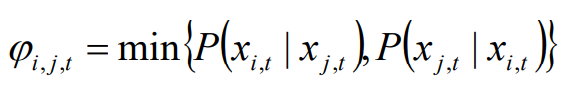

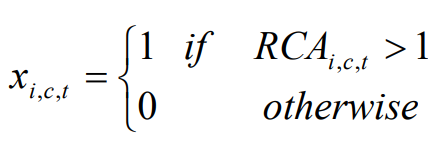

Entonces se define la proximidad entre los bienes i y j como: 

$$ \phi_{ij} = \min {P(VCR_i>=1|VCR_j>=1), P(VCR_j>=1|VCR_i>=1)} $$ 
o simplificando la notación:
$$ \phi_{ij} = \min {P(i|j), P(j|i)} $$ 

donde $P(VCR_i>=1|VCR_j>=1)$ es la probabilidad condicional de exportar el bien i dado que se exporta el bien j (y viceversa). Según los autores al considerar el mínimo entre ambas probabilidades condicionales se resuelve el problema de que en el caso de que un país sea el único exportador de un bien en particular la probabilidad condicional de exportar cualquier otro bien dado ese sería igual a uno para todos los demás bienes exportados por ese país, y asimismo, se logra una matriz de proximidad simétrica.

$$ P(i|j) = \frac{  Pconj(i,j) }{ P(j) } $$ 

* $ P(i) = I/N $ : probabilidad de exportar i => proporción de exportaciones de i

* $ P(j)= J/N $ : probabilidad de exportar j => proporción  de exportaciones de j

* $ Pconj(i,j) $ : probab conjunta de que se exporte i y j al mismo tiempo

Calcular la proximidad en base a la mínima probabilidad conjunta de P(i/j) y P(j/i), es lo mismo que calcular la proximidad en base al que tenga máxima probabilidad individual P(i) o P(j) dado que el numerador (probabilidad conjunta) de las probabilidades condicionales es igual para ambas y lo que cambia es el denominador.  

Defino mi propia matriz de proximidad pero termino usando una de las matrices que propone Matthew McKay dado que tiene mejor performance. Es más rápida. Ambas dan idéntico resultado.

In [191]:
def my_own_proximity_matrix(mvcr, fillna=False):
    products = sorted(list(mvcr.columns))                     # lista ordenada de productos
    num_products = len(products)                              # cantidad de bienes de la base 
    proximity = np.empty((num_products, num_products))        # armo una matriz vacía de nxn siendo n = cant prod
    col_sums = mvcr.sum().values                              # sumo elementos de las cols (nro de paises que exportan cada bien)
    data = mvcr.T.to_numpy()                                  
    for i in range(0,num_products):                           # recorro todo el universo de productos para i y j
        for j in range(0,num_products):                       
            P_i = data[i].sum()/data.sum()                    # P_i = I/N -proporción de países que exportan i-
            P_j = data[j].sum()/data.sum()                    # P_j = J/N -proporción de países que exportan j-
            P_conj_ij = ((data[i] + data[j])==2).sum()/data.sum()  # P_conj_ij = P(i/j)*P(j) -probab de que i y j sean ambos = 1- 
            if P_j == 0.0:
                P_i_cond_j = np.nan
            else:
                P_i_cond_j = P_conj_ij / P_j
            if P_i == 0.0:
                P_j_cond_i = np.nan
            else:
                P_j_cond_i = P_conj_ij / P_i
            cond_prob = min(P_i_cond_j, P_j_cond_i)           # calculo el minimo entre las prob condicionales
            proximity[i][j] = cond_prob                       # armo las matrices de proximidad simétricas
            proximity[j][i] = cond_prob
    # Return DataFrame Representation #
    proximity = pd.DataFrame(proximity, index=products, columns=products)
    proximity.index.name = 'product_i'
    proximity.columns.name = 'product_j'
    if fillna:
        proximity = proximity.fillna(0.0)
    return proximity

**Usando las definiciones de Matthew McKay**

Usa 3 métodos distintos, en este caso uso numpy y numba. Usando el paquete [Numba](http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html) se puede acelerar el código usando una técnica llamada compilación justo a tiempo (o JIT). Convierte el código Python de alto nivel en código llvm de bajo nivel para ejecutarlo más cerca del nivel de máquina sin procesar. Así se aceleran los tiempos de procesamiento y ejecución. Pruebo ambos métodos. 

In [192]:
# Usando las funciones de Matthew McKay que tienen mejor performance
def proximity_matrix_numpy(mvcr, fillna=False):
    products = sorted(list(mvcr.columns))                     # lista ordenada de productos
    num_products = len(products)                              # cantidad de bienes de la base 
    proximity = np.empty((num_products, num_products))        # armo una matriz vacía de nxn siendo n = cant prod
    col_sums = mvcr.sum().values                              # sumo elementos de las cols (nro de paises que exportan cada bien)
    data = mvcr.T.to_numpy()                                  # reemplazo as_matrix() por to_numpy() ya que "Deprecated since version 0.23.0"
    for i in range(0,num_products):
        for j in range(0,num_products):
            if j > i:
                continue
            numerator = (data[i] * data[j]).sum()             # calcula la probabilidad de intersección de i y j
            denominator = max(col_sums[i], col_sums[j])       # como el numerador -probab conj- es = para ambas, 
            if denominator == 0.0:                            # usa el max denominador -probab individual- 
                cond_prob = np.nan                            # para obtener la min prob condicional
            else:
                cond_prob = numerator / denominator
            proximity[i][j] = cond_prob
            proximity[j][i] = cond_prob
    # Return DataFrame Representation #
    proximity = pd.DataFrame(proximity, index=products, columns=products)
    proximity.index.name = 'product_i'
    proximity.columns.name = 'product_j'
    if fillna:
        proximity = proximity.fillna(0.0)
    return proximity

In [193]:
from numba import njit
@njit()
def probab_condicional(data, num_products, col_sums):
    proximity = np.empty((num_products, num_products))
    for i in range(0,num_products):
        for j in range(0,num_products):
            if j > i:
                continue
            numerator = (data[i] * data[j]).sum()             # calcula la probabilidad de intersección de i y j
            denominator = max(col_sums[i], col_sums[j])       # como el numerador -probab conj- es = para ambas, 
            if denominator == 0.0:                            # usa el max denominador -probab individual- 
                cond_prob = np.nan                            # para obtener la min prob condicional
            else:
                cond_prob = numerator / denominator
            proximity[i][j] = cond_prob
            proximity[j][i] = cond_prob
    return proximity

In [194]:
def proximity_matrix_numba(mvcr, fillna=False):
    products = sorted(list(mvcr.columns))
    num_products = len(products)
    col_sums = mvcr.sum().values  
    data = mvcr.T.to_numpy()                  
    proximity = probab_condicional(data, num_products, col_sums)   #Call Jit Function
    # Return DataFrame Representation #
    proximity = pd.DataFrame(proximity, index=products, columns=products)
    proximity.index.name = 'product_i'
    proximity.columns.name = 'product_j'
    if fillna:
        proximity = proximity.fillna(0.0)
    return proximity

**Pruebo los cálculos individuales primero para entender bien cada paso de la función**

In [446]:
# ordeno los productos y saco la cantidad
len(sorted(list(MVCR1['1719'].columns)))

1241

In [447]:
np.empty((2, 2))

array([[6.95264822e-310, 6.95264822e-310],
       [6.95264822e-310, 6.95264822e-310]])

In [448]:
MVCR1['1719'].sum(axis=0) # sumo datos por columna => cantidad de paìses que exportan cada bien (1241 prods)

ProductCode
101     17.0
102     36.0
103     18.0
104     21.0
105     30.0
        ... 
9702     7.0
9703    13.0
9704    14.0
9705    12.0
9706    11.0
Length: 1241, dtype: float64

In [449]:
MVCR1['1719'].sum(axis=1) # sumo datos por fila => cantidad de bienes que exporta cada pais (109 países)

ReporterISO3
ALB     98.0
AND    133.0
ARE     81.0
ARG    156.0
ARM     99.0
       ...  
URY    112.0
USA    462.0
VCT     65.0
ZAF    248.0
ZMB     81.0
Length: 109, dtype: float64

In [450]:
MVCR1['1719'].sum() # si no aclaro sumo las columnas 

ProductCode
101     17.0
102     36.0
103     18.0
104     21.0
105     30.0
        ... 
9702     7.0
9703    13.0
9704    14.0
9705    12.0
9706    11.0
Length: 1241, dtype: float64

In [451]:
MVCR1['1719'].sum().values # convierto en array

array([17., 36., 18., ..., 14., 12., 11.])

In [452]:
MVCR1['1719'].sum().sum() # suma de todos los productos exportados por todos los países

19859.0

In [453]:
MVCR1['1719'].sum().values[0] # voy recorriendo los valores => esto vendría a ser mi J o I -nro de paises q exportan j o i-

17.0

In [454]:
MVCR1['1719'].T.to_numpy() # traspongo el data frame para tener los productos en filas y convierto el df en matriz

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [455]:
MVCR1['1719'].T.to_numpy().sum()

19859.0

In [456]:
MVCR1['1719'].T.to_numpy()[0] # chequeo datos para el primer producto -101-

array([0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0.])

In [457]:
MVCR1['1719'][101].to_numpy() # chequeo datos para el primer producto -101-

array([0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0.])

In [459]:
MVCR1['1719'].T.to_numpy()[0] == MVCR1['1719'][101].to_numpy()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [460]:
MVCR1['1719'].columns

Int64Index([ 101,  102,  103,  104,  105,  106,  201,  202,  203,  204,
            ...
            9615, 9616, 9617, 9618, 9701, 9702, 9703, 9704, 9705, 9706],
           dtype='int64', name='ProductCode', length=1241)

In [461]:
((MVCR1['1719'].T.to_numpy()[0] + MVCR1['1719'].T.to_numpy()[1]) == 2).sum()

9

### Armo la matriz de proximidad para 1719

### <span style="color:steelblue"> Dataset 1: </span>todos los períodos - 109 países

In [210]:
# armo matriz de proximidad con mi funcion
# prox_mat_1719 = my_own_proximity_matr### <span style="color:steelblue"> Dataset 1: </span>todos los períodos - 109 paísesix(MVCR1['1719']) 
# tardó demasiado tiempo, asi que voy a usar la otra funcion pero ya sé cómo la calculó

In [211]:
# chequeo mi matriz de proximidad que dio igual que la anterior
# prox_mat_1719

In [212]:
# histograma de la matriz de proximidad
# prox_mat_1719.unstack().hist()

In [462]:
prox_1719_numpy = proximity_matrix_numpy(MVCR1['1719'])

In [463]:
# analizo la distribucion de la matriz
prox_1719_numpy.unstack().describe()

count    1.539505e+06
mean     1.656770e-01
std      1.161497e-01
min      0.000000e+00
25%      8.000000e-02
50%      1.538462e-01
75%      2.352941e-01
max      1.000000e+00
dtype: float64

In [464]:
# veo matriz de proximidad
prox_1719_numpy

product_j,101,102,103,104,105,106,201,202,203,204,...,9615,9616,9617,9618,9701,9702,9703,9704,9705,9706
product_i,,,,,,,,,,,,,,,,,,,,,
101,1.000000,0.250000,0.277778,0.142857,0.266667,0.228571,0.454545,0.352941,0.294118,0.352941,...,0.058824,0.058824,0.000000,0.294118,0.294118,0.294118,0.235294,0.470588,0.352941,0.235294
102,0.250000,1.000000,0.416667,0.361111,0.444444,0.388889,0.444444,0.194444,0.222222,0.250000,...,0.027778,0.083333,0.027778,0.166667,0.055556,0.027778,0.083333,0.166667,0.111111,0.083333
103,0.277778,0.416667,1.000000,0.190476,0.300000,0.285714,0.409091,0.055556,0.388889,0.166667,...,0.000000,0.111111,0.055556,0.222222,0.000000,0.055556,0.000000,0.222222,0.055556,0.055556
104,0.142857,0.361111,0.190476,1.000000,0.433333,0.285714,0.181818,0.095238,0.095238,0.238095,...,0.000000,0.095238,0.000000,0.142857,0.047619,0.000000,0.095238,0.047619,0.142857,0.142857
105,0.266667,0.444444,0.300000,0.433333,1.000000,0.485714,0.366667,0.166667,0.333333,0.166667,...,0.033333,0.100000,0.033333,0.266667,0.100000,0.066667,0.166667,0.133333,0.300000,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9702,0.294118,0.027778,0.055556,0.000000,0.066667,0.057143,0.045455,0.066667,0.076923,0.066667,...,0.142857,0.000000,0.000000,0.125000,0.500000,1.000000,0.384615,0.285714,0.333333,0.363636
9703,0.235294,0.083333,0.000000,0.095238,0.166667,0.142857,0.136364,0.200000,0.153846,0.066667,...,0.000000,0.153846,0.000000,0.187500,0.461538,0.384615,1.000000,0.214286,0.384615,0.538462
9704,0.470588,0.166667,0.222222,0.047619,0.133333,0.085714,0.227273,0.200000,0.214286,0.333333,...,0.000000,0.000000,0.000000,0.187500,0.142857,0.285714,0.214286,1.000000,0.357143,0.142857


<AxesSubplot:>

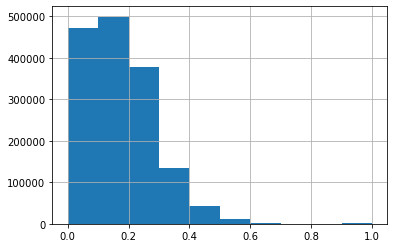

In [465]:
# histograma de la matriz de proximidad
prox_1719_numpy.unstack().hist()

In [467]:
# pruebo con numba
proximity_matrix_numba(MVCR1['1719']) # es mucho más rápida que numpy

product_j,101,102,103,104,105,106,201,202,203,204,...,9615,9616,9617,9618,9701,9702,9703,9704,9705,9706
product_i,,,,,,,,,,,,,,,,,,,,,
101,1.000000,0.250000,0.277778,0.142857,0.266667,0.228571,0.454545,0.352941,0.294118,0.352941,...,0.058824,0.058824,0.000000,0.294118,0.294118,0.294118,0.235294,0.470588,0.352941,0.235294
102,0.250000,1.000000,0.416667,0.361111,0.444444,0.388889,0.444444,0.194444,0.222222,0.250000,...,0.027778,0.083333,0.027778,0.166667,0.055556,0.027778,0.083333,0.166667,0.111111,0.083333
103,0.277778,0.416667,1.000000,0.190476,0.300000,0.285714,0.409091,0.055556,0.388889,0.166667,...,0.000000,0.111111,0.055556,0.222222,0.000000,0.055556,0.000000,0.222222,0.055556,0.055556
104,0.142857,0.361111,0.190476,1.000000,0.433333,0.285714,0.181818,0.095238,0.095238,0.238095,...,0.000000,0.095238,0.000000,0.142857,0.047619,0.000000,0.095238,0.047619,0.142857,0.142857
105,0.266667,0.444444,0.300000,0.433333,1.000000,0.485714,0.366667,0.166667,0.333333,0.166667,...,0.033333,0.100000,0.033333,0.266667,0.100000,0.066667,0.166667,0.133333,0.300000,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9702,0.294118,0.027778,0.055556,0.000000,0.066667,0.057143,0.045455,0.066667,0.076923,0.066667,...,0.142857,0.000000,0.000000,0.125000,0.500000,1.000000,0.384615,0.285714,0.333333,0.363636
9703,0.235294,0.083333,0.000000,0.095238,0.166667,0.142857,0.136364,0.200000,0.153846,0.066667,...,0.000000,0.153846,0.000000,0.187500,0.461538,0.384615,1.000000,0.214286,0.384615,0.538462
9704,0.470588,0.166667,0.222222,0.047619,0.133333,0.085714,0.227273,0.200000,0.214286,0.333333,...,0.000000,0.000000,0.000000,0.187500,0.142857,0.285714,0.214286,1.000000,0.357143,0.142857


In [468]:
# Creo diccionario con los datos de las matrices de proximidad para cada periodo
##time
proximity1 = {}
for year in MVCR1.keys():
    proximity1[year] = proximity_matrix_numba(MVCR1[year])

In [469]:
proximity1

{'1719': product_j      101       102       103       104       105       106   \
 product_i                                                               
 101        1.000000  0.250000  0.277778  0.142857  0.266667  0.228571   
 102        0.250000  1.000000  0.416667  0.361111  0.444444  0.388889   
 103        0.277778  0.416667  1.000000  0.190476  0.300000  0.285714   
 104        0.142857  0.361111  0.190476  1.000000  0.433333  0.285714   
 105        0.266667  0.444444  0.300000  0.433333  1.000000  0.485714   
 ...             ...       ...       ...       ...       ...       ...   
 9702       0.294118  0.027778  0.055556  0.000000  0.066667  0.057143   
 9703       0.235294  0.083333  0.000000  0.095238  0.166667  0.142857   
 9704       0.470588  0.166667  0.222222  0.047619  0.133333  0.085714   
 9705       0.352941  0.111111  0.055556  0.142857  0.300000  0.171429   
 9706       0.235294  0.083333  0.055556  0.142857  0.166667  0.114286   
 
 product_j      201       20

In [470]:
proximity1['1719']

product_j,101,102,103,104,105,106,201,202,203,204,...,9615,9616,9617,9618,9701,9702,9703,9704,9705,9706
product_i,,,,,,,,,,,,,,,,,,,,,
101,1.000000,0.250000,0.277778,0.142857,0.266667,0.228571,0.454545,0.352941,0.294118,0.352941,...,0.058824,0.058824,0.000000,0.294118,0.294118,0.294118,0.235294,0.470588,0.352941,0.235294
102,0.250000,1.000000,0.416667,0.361111,0.444444,0.388889,0.444444,0.194444,0.222222,0.250000,...,0.027778,0.083333,0.027778,0.166667,0.055556,0.027778,0.083333,0.166667,0.111111,0.083333
103,0.277778,0.416667,1.000000,0.190476,0.300000,0.285714,0.409091,0.055556,0.388889,0.166667,...,0.000000,0.111111,0.055556,0.222222,0.000000,0.055556,0.000000,0.222222,0.055556,0.055556
104,0.142857,0.361111,0.190476,1.000000,0.433333,0.285714,0.181818,0.095238,0.095238,0.238095,...,0.000000,0.095238,0.000000,0.142857,0.047619,0.000000,0.095238,0.047619,0.142857,0.142857
105,0.266667,0.444444,0.300000,0.433333,1.000000,0.485714,0.366667,0.166667,0.333333,0.166667,...,0.033333,0.100000,0.033333,0.266667,0.100000,0.066667,0.166667,0.133333,0.300000,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9702,0.294118,0.027778,0.055556,0.000000,0.066667,0.057143,0.045455,0.066667,0.076923,0.066667,...,0.142857,0.000000,0.000000,0.125000,0.500000,1.000000,0.384615,0.285714,0.333333,0.363636
9703,0.235294,0.083333,0.000000,0.095238,0.166667,0.142857,0.136364,0.200000,0.153846,0.066667,...,0.000000,0.153846,0.000000,0.187500,0.461538,0.384615,1.000000,0.214286,0.384615,0.538462
9704,0.470588,0.166667,0.222222,0.047619,0.133333,0.085714,0.227273,0.200000,0.214286,0.333333,...,0.000000,0.000000,0.000000,0.187500,0.142857,0.285714,0.214286,1.000000,0.357143,0.142857


In [472]:
# Guardo el diccionario como pickle para poder usarlo luego sin volver a correr todo
prox_matrix_to_pkl1 = open("../data/processed/proximity_matrix1.pkl", "wb")
pickle.dump(proximity1, prox_matrix_to_pkl1)
prox_matrix_to_pkl1.close()

### <span style="color:steelblue">Dataset 2: </span>últimos 2 períodos - 157 países

In [473]:
# Creo diccionario con los datos de las matrices de proximidad para cada periodo
proximity2 = {}
for year in MVCR2.keys():
    proximity2[year] = proximity_matrix_numba(MVCR2[year])

In [474]:
proximity2

{'1719': product_j      101       102       103       104       105       106   \
 product_i                                                               
 101        1.000000  0.232558  0.263158  0.142857  0.270270  0.166667   
 102        0.232558  1.000000  0.348837  0.395349  0.395349  0.333333   
 103        0.263158  0.348837  1.000000  0.142857  0.243243  0.208333   
 104        0.142857  0.395349  0.142857  1.000000  0.351351  0.270833   
 105        0.270270  0.395349  0.243243  0.351351  1.000000  0.416667   
 ...             ...       ...       ...       ...       ...       ...   
 9702       0.263158  0.023256  0.000000  0.035714  0.108108  0.062500   
 9703       0.263158  0.116279  0.000000  0.071429  0.189189  0.125000   
 9704       0.368421  0.116279  0.166667  0.035714  0.162162  0.104167   
 9705       0.368421  0.116279  0.000000  0.142857  0.243243  0.145833   
 9706       0.263158  0.069767  0.000000  0.107143  0.162162  0.083333   
 
 product_j      201       20

In [475]:
proximity2['1719']

product_j,101,102,103,104,105,106,201,202,203,204,...,9615,9616,9617,9618,9701,9702,9703,9704,9705,9706
product_i,,,,,,,,,,,,,,,,,,,,,
101,1.000000,0.232558,0.263158,0.142857,0.270270,0.166667,0.370370,0.285714,0.315789,0.347826,...,0.052632,0.105263,0.000000,0.315789,0.263158,0.263158,0.263158,0.368421,0.368421,0.263158
102,0.232558,1.000000,0.348837,0.395349,0.395349,0.333333,0.418605,0.255814,0.209302,0.302326,...,0.046512,0.069767,0.023256,0.162791,0.069767,0.023256,0.116279,0.116279,0.116279,0.069767
103,0.263158,0.348837,1.000000,0.142857,0.243243,0.208333,0.333333,0.047619,0.388889,0.173913,...,0.055556,0.111111,0.055556,0.222222,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000
104,0.142857,0.395349,0.142857,1.000000,0.351351,0.270833,0.178571,0.142857,0.107143,0.321429,...,0.000000,0.035714,0.000000,0.107143,0.035714,0.035714,0.071429,0.035714,0.142857,0.107143
105,0.270270,0.395349,0.243243,0.351351,1.000000,0.416667,0.324324,0.162162,0.297297,0.189189,...,0.054054,0.108108,0.027027,0.270270,0.108108,0.108108,0.189189,0.162162,0.243243,0.162162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9702,0.263158,0.023256,0.000000,0.035714,0.108108,0.062500,0.037037,0.047619,0.142857,0.043478,...,0.100000,0.125000,0.000000,0.111111,0.500000,1.000000,0.375000,0.357143,0.357143,0.454545
9703,0.263158,0.116279,0.000000,0.071429,0.189189,0.125000,0.111111,0.142857,0.187500,0.043478,...,0.000000,0.187500,0.000000,0.166667,0.437500,0.375000,1.000000,0.250000,0.437500,0.500000
9704,0.368421,0.116279,0.166667,0.035714,0.162162,0.104167,0.148148,0.095238,0.285714,0.173913,...,0.000000,0.000000,0.000000,0.166667,0.214286,0.357143,0.250000,1.000000,0.285714,0.214286


In [476]:
# Guardo el diccionario como pickle para poder usarlo luego sin volver a correr todo
prox_matrix_to_pkl2 = open("../data/processed/proximity_matrix2.pkl", "wb")
pickle.dump(proximity2, prox_matrix_to_pkl2)
prox_matrix_to_pkl2.close()